In [1]:
from Data import data_processing as dp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from Fcnn.fcnn_analysis import analyze_fcnn_model
from sklearn.metrics import precision_score, recall_score

In [2]:
X_train, X_test, y_train, y_test, vectorizer = dp.get_training_data()

In [3]:
# Define the fully connected neural network
class FCNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FCNN, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 64)  # First hidden layer
        self.output = nn.Linear(64, output_dim)  # Output layer

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.output(x)  # Logits (raw scores)
        return x


In [4]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [5]:
# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [6]:
# Initialize the model
input_dim = X_train.shape[1]
output_dim = len(set(y_train))  # Number of classes (e.g., 2 for binary classification)
model = FCNN(input_dim, output_dim)

In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Create a dictionary to store training metrics
train_metrics = {
    'losses': [],
    'accuracies': []
}
# Train the model
epochs = 5
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Clear gradients
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Track metrics
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    # Store metrics for visualization
    train_metrics['losses'].append(epoch_loss)
    train_metrics['accuracies'].append(accuracy)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/5, Loss: 170.8882, Accuracy: 0.8951
Epoch 2/5, Loss: 59.9329, Accuracy: 0.9597
Epoch 3/5, Loss: 36.8408, Accuracy: 0.9763
Epoch 4/5, Loss: 24.3787, Accuracy: 0.9860
Epoch 5/5, Loss: 17.1919, Accuracy: 0.9907


In [9]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    test_predictions = predicted.cpu().numpy()
    test_targets = y_test_tensor.cpu().numpy()
    
    test_accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    test_precision = precision_score(test_targets, test_predictions, average='weighted')
    test_recall = recall_score(test_targets, test_predictions, average='weighted')

print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")


Test Set Metrics:
Accuracy: 0.9224
Precision: 0.9224
Recall: 0.9224


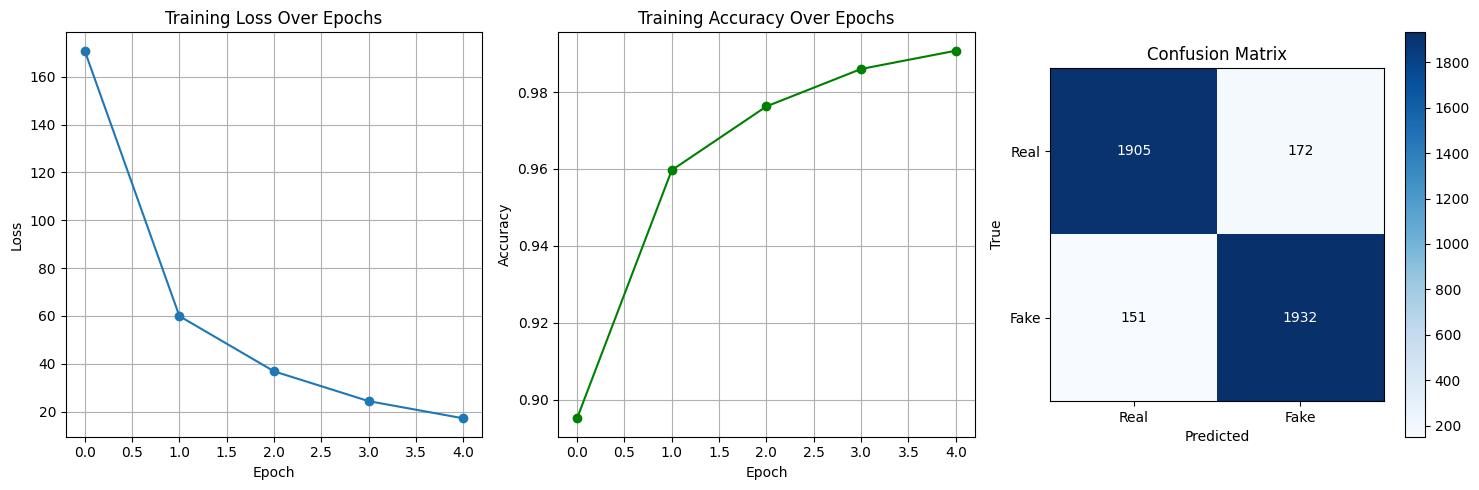

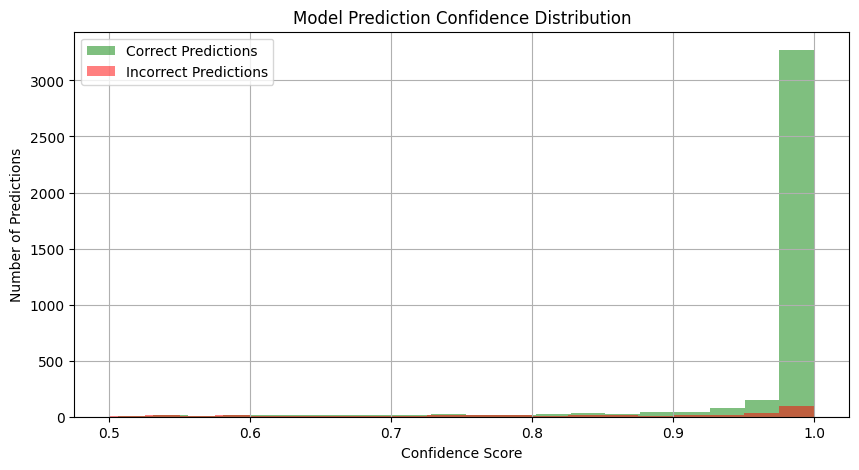


=== Model Performance Summary ===

Confusion Matrix:
                  Predicted
                  Real    Fake
Actual Real:     1905     172
      Fake:     151     1932

Classification Report:
              precision    recall  f1-score   support

        Real       0.93      0.92      0.92      2077
        Fake       0.92      0.93      0.92      2083

    accuracy                           0.92      4160
   macro avg       0.92      0.92      0.92      4160
weighted avg       0.92      0.92      0.92      4160


Final Test Accuracy: 0.9224
Average Confidence: 0.9645


In [10]:
analyze_fcnn_model(model, train_metrics, X_test_tensor, y_test_tensor)